In [20]:
import numpy as np
import scipy.linalg as la
import itertools as it
import time
import pylab as pl
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.stats import lognorm

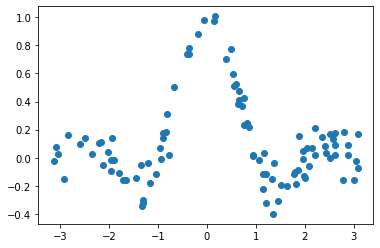

In [45]:
# Test
def noisysincfunction(N, noise):
    ''' noisysincfunction - generate data from the "noisy sinc function"
        % usage
        %     [X, Y] = noisysincfunction(N, noise)
        %
        % input
        %     N: number of data points
        %     noise: standard variation of the noise
        %
        % output
        %     X: (1, N)-matrix uniformly sampled in -2pi, pi
        %     Y: (1, N)-matrix equal to sinc(X) + noise
        %
        % description
        %     Generates N points from the noisy sinc function
        %
        %        X ~ uniformly in [-2pi, pi]
        %        Y = sinc(X) + eps, eps ~ Normal(0, noise.^2)
        %
        % author
        %     Mikio Braun
    '''
    X = np.sort(2 * np.pi * np.random.rand(1, N) ) - np.pi
    Y = np.sinc(X) + noise * np.random.randn(1, N)
    return X.reshape(-1, 1), Y.flatten()
Xtr, Ytr = noisysincfunction(100, 0.1)
Xte = np.arange( -np.pi, np.pi, 0.01 ).reshape(-1, 1)
pl.plot(Xtr,Ytr, 'o')

In [3]:
def zero_one_loss(y_true, y_pred):
    ''' your header here!
    '''
    

In [4]:
def mean_absolute_error(y_true, y_pred):
    ''' 
    your code here 
    '''
    loss = np.sum(((y_pred-y_true)**2)**0.5) / len(y_pred)
    return loss

In [47]:
def cv(X, y, method, params, loss_function=mean_absolute_error, nfolds=10, nrepetitions=5):
    ''' 
    your header here!
    '''
    # TODO progress bar, run time estimation
    length, width = np.shape(X)
    # model = method
    method.cvloss = 1000000
    params_combinations = list(it.product(params['kernel'], params['kernelparameter'], params['regularization']))
    for parameter in params_combinations:
        #print(parameter[1])
        model = method(parameter[0], parameter[1], parameter[2])
        for i in range(nrepetitions):
            e = 0
            # Random Partitioning
            X_pos = np.linspace(0,length-1, length)
            random.shuffle(X_pos)
            part = np.array_split(X_pos, nfolds)
            for j in range(nfolds):
                # Assign every part not j as training set
                # Xtr indices
                train = np.concatenate(np.array(part)[tuple([np.array(range(nfolds)) != j])].astype('int')) 
                X_j = X[train]
                y_j = y[train]
                model.fit(X_j, y_j)
                y_pred = model.predict(X[part[j].astype('int')])
                e = e + loss_function(y[part[j].astype('int')], y_pred)
        e = e / (nfolds * nrepetitions)
        #print('Loss:' + str(model.cvloss))
        if e < method.cvloss:
            #print(e)
            method.cvloss = e
            #print('Loss in if:' + str(model.cvloss))
            method.__params = parameter
    #print(method.params)
    method = model.fit(X,y,method.__params[0],method.__params[1],method.__params[2])
    return method

In [627]:
class krr():
    ''' your header here!
    '''
    def __init__(self, kernel='linear', kernelparameter=1, regularization=0):
        self.kernel = kernel
        self.kernelparameter = kernelparameter
        self.regularization = regularization

    def fit(self, X, y, kernel=False, kernelparameter=False, regularization=False):
        ''' your header here!
        '''
        self.__Xtrain = X
        self.__ytrain = y
        
        if kernel is not False:
            self.kernel = kernel
        if kernelparameter is not False:
            self.kernelparameter = kernelparameter
        if regularization is not False:
            self.regularization = regularization
        # calculate kernelmatrix
        if self.kernel == 'linear':
            self.__linearKernel(X)
        elif self.kernel == 'polynomial':
            self.__polynomialKernel(X)
        elif self.kernel == 'gaussian':
            self.__gaussianKernel(X)
        else:
            print("""The following kernel {} is not known. Please use either 'linear' , 'polynomial' or 'gaussian'.""".format(kernel))
        if self.regularization == 0:
            self.__LOOCV()
        
        # calculate optimized alpha
        I_length = len(self.kernelmatrix)
        self.alpha = np.linalg.solve(self.kernelmatrix+self.regularization*np.identity(I_length), self.__ytrain).reshape(-1,len(self.__ytrain))
        
        return self

    def predict(self, X):
        ''' your header here!
        '''
        # calculate kernelmatrix
        if self.kernel == 'linear':
            self.__linearKernel(X)
        elif self.kernel == 'polynomial':
            self.__polynomialKernel(X)
        elif self.kernel == 'gaussian':
            self.__gaussianKernel(X)
        # calculate prediction
        y_pred = self.alpha.dot(self.kernelmatrix) # <alpha, kernelmatrix>
        return y_pred.reshape(len(X))
    
    def __linearKernel(self,Y):
        self.kernelmatrix = self.__Xtrain.dot(Y.T)
        
    def __polynomialKernel(self,Y):
        self.kernelmatrix = (self.__Xtrain.dot(Y.T)+1)**self.kernelparameter
        
    def __gaussianKernel(self,Y):
        X_len, X_width = self.__Xtrain.shape
        self.kernelmatrix = np.exp(-(np.diagonal(self.__Xtrain.dot(self.__Xtrain.T)).reshape(X_len, 1)-2*self.__Xtrain.dot(Y.T)+np.diagonal(Y.dot(Y.T)))/(2*(self.kernelparameter**2)))
        
    def __LOOCV(self):
        # Leave-One-Out-Cross-Validation
        # starting squared error
        #min_squared_loss = 1000
        # Eigenvalue decomposition
        squared_loss = []
        L, U = np.linalg.eigh(self.kernelmatrix) # L = Eigenvalue, U = Eigenvector
        mean_L = np.mean(L)
        I = np.identity(len(L))
        # for faster computation precalculate U.T.y
        UTy = U.T.dot(self.__ytrain)
        # logarithmic distribution with mu = mean_L and sigma = 1
        # create 50 values of C
        # identify C around Kernel eigenvalue means with logarithmic distribution 
        Cs = np.logspace(-10, 10, 50)*mean_L
        for C in Cs: #np.random.lognormal(mean_L,sigma = 1, size = 30):
            ULCI = U.dot(L*I).dot((1/(L + C))*I) # (1/(L + C))*I: inverse of diagonal matrix
            squared_loss.append(np.sum(((self.__ytrain - ULCI.dot(UTy)) / (1-np.diagonal(ULCI.dot(U.T))))**2) / len(self.__ytrain))
        self.regularization = Cs[np.argmin(squared_loss)]
                
        # Eigenvalue decomposition
        #L, U = np.linalg.eigh(self.kernelmatrix) # L = Eigenvalue, U = Eigenvector
        #mean_L = np.mean(L)        
                
        # create candidates
        #C = np.logspace(-10, 10, 50)*mean_L
        
        #UTy = U.T.dot(self.__ytrain)
        # 
        #UL = U.dot(np.diag(L))[None,:,:]
        #LC = np.diag(L)[None,:,:]+C[:,None,None]*I[None,:,:]
        #ULCI = np.linalg.solve(LC,UL)
        
        #calculate all quadratic losses for c candidates
        #c   =    0xnx1-cxnx1 / (1-cxn)
        #epsilon = (np.sum(((Ytr - ULCI.dot(UTy)) / (1-np.diagonal(ULCI.dot(U.T))).reshape(len(C),len(Ytr)))**2, axis = 1) /len(Ytr))
    
        #best_epsilon = epsilon[np.argmin(epsilon)]
    
        #self.regularization = C[np.argmin(epsilon)]        
        
        return self

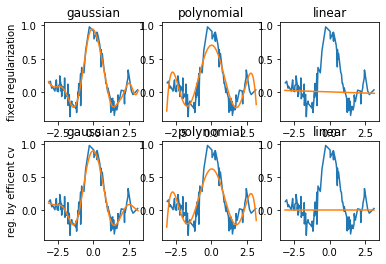

In [628]:
Xtr, Ytr = noisysincfunction(100, 0.1)
Xte = np.arange( -np.pi, np.pi, 0.01 ).reshape(-1, 1)

pl.figure()
kernels = ['gaussian','polynomial','linear']
titles = ['gaussian','polynomial','linear']
params = [0.5,6,0]
regularizations = [ 0.01,0.01,0.01]
for i in range(3):
    for j in range(2):
        pl.subplot(2,3,1+i+3*j)
        if j==0:
            model = krr(kernel=kernels[i],
                kernelparameter=params[i],
                regularization=regularizations[i])
            model.fit(Xtr,Ytr)
        if j==1:
            model = krr(kernel=kernels[i],
                kernelparameter=params[i],
                regularization=0)
            model.fit(Xtr,Ytr)
        ypred = model.predict(Xte)
        pl.plot(Xtr,Ytr)
        pl.plot(Xte,ypred)
        if j==0 and i == 0:
            pl.ylabel('fixed regularization')
        if j==1 and i == 0:
            pl.ylabel('reg. by efficent cv')
        pl.title( titles[i] )
pl.show()


Regularization range: 10**-4 .. 10**4
Gaussian kernel parameter:  0.615848211066026
Regularization paramter:  0.21544346900318834
Regularization via efficient leave on out
Kernel parameter:  1.6681005372000592
Regularization paramter:  2.0235896477251552e-05


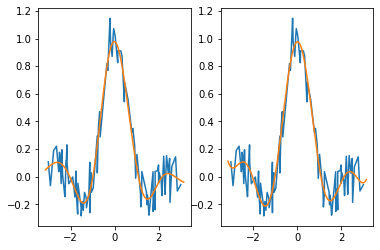

In [658]:
Xtr, Ytr = noisysincfunction(100, 0.1)
Xte = np.arange( -np.pi, np.pi, 0.01 ).reshape(-1, 1)

pl.figure()
pl.subplot(1,2,1)
params = { 'kernel': ['gaussian'], 'kernelparameter': np.logspace(-4,4,20), 'regularization': np.logspace(-2,2,10) }
cvkrr = cv(Xtr, Ytr, krr, params, loss_function=mean_absolute_error, nrepetitions=2)
ypred = cvkrr.predict(Xte)
print('Regularization range: 10**-4 .. 10**4')
print('Gaussian kernel parameter: ', cvkrr.kernelparameter)
print('Regularization paramter: ', cvkrr.regularization)

pl.plot(Xtr,Ytr)
pl.plot(Xte,ypred)

pl.subplot(1,2,2)
params = { 'kernel': ['gaussian'], 'kernelparameter': np.logspace(-2,2,10), 'regularization': [0]}
cvkrr = cv(Xtr, Ytr, krr, params, loss_function=mean_absolute_error, nrepetitions=2)
ypred = cvkrr.predict(Xte)
print('Regularization via efficient leave on out')
print('Kernel parameter: ', cvkrr.kernelparameter)
print('Regularization paramter: ', cvkrr.regularization)

pl.plot(Xtr,Ytr)
pl.plot(Xte,ypred)
pl.show()

In [645]:
params = { 'kernel': ['gaussian'], 'kernelparameter': 0.01, 'regularization': 0.1 }


In [646]:
model = krr(kernel='gaussian',kernelparameter=params['kernelparameter'],regularization=params['regularization'])

In [647]:
model.fit(Xtr,Ytr)

In [648]:
model.kernelmatrix

array([[1.00000000e+000, 4.99595355e-018, 1.36048678e-077, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [4.99595355e-018, 1.00000000e+000, 5.85755893e-022, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [1.36048678e-077, 5.85755893e-022, 1.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       ...,
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        1.00000000e+000, 4.20717335e-029, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        4.20717335e-029, 1.00000000e+000, 8.53360808e-230],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 8.53360808e-230, 1.00000000e+000]])

In [649]:
L, U = np.linalg.eigh(model.kernelmatrix)
mean_L = np.mean(L)        
# create candidates
C = np.logspace(-10, 10, 50)*mean_L
I = np.identity(len(L))

In [650]:
UTy = U.T.dot(Ytr)#self.__ytrain

In [651]:
UL = U.dot(np.diag(L))[None,:,:]

In [652]:
LC.shape

(50, 100, 100)

In [653]:
LC = np.diag(L)[None,:,:]+C[:,None,None]*I[None,:,:]

In [654]:
#ULCI_1 = U.dot(L*I).dot((1/(L + C))*I) # (1/(L + C))*I: inverse of diagonal matrix
#ULCI = np.linalg.solve((L + C)*I,U.dot(L*I))
ULCI_2 = UL*((np.linalg.inv(LC)))

In [656]:
ULCI_2.shape

(50, 100, 100)

In [657]:
ULCI_2[20]

array([[ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000, -0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [-0.00000000e+000,  0.00000000e+000,  8.85725547e-201, ...,
        -0.00000000e+000, -0.00000000e+000,  0.00000000e+000],
       ...,
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000, -0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000, -0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000]])

In [476]:
#solve
(Ytr - ULCI.dot(UTy)).shape

(50, 100)

In [491]:
C[20]

0.014563484775012445

In [494]:
# solve
(np.sum(((Ytr - ULCI.dot(UTy)) / (1-np.diagonal(ULCI.dot(U.T))).reshape(len(C),len(Ytr)))**2, axis = 1) /len(Ytr))[24]

0.011217768345839985

In [467]:
np.sum(((Ytr - ULCI.dot(UTy))[20] / (1-np.diagonal(ULCI[20].dot(U.T))))**2) / len(Ytr)

116.2904633374159

In [451]:
# loop
ULCI

array([[ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       ...,
       [ 4.11342324e-114, -1.75286977e-101, -1.21497129e-030, ...,
         0.00000000e+000,  4.26591704e-223, -1.53231091e-109],
       [ 2.94430502e-117, -1.25464773e-104, -2.62997037e-032, ...,
         0.00000000e+000,  7.90863509e-228, -6.64577544e-113],
       [ 2.58313699e-117, -1.10074285e-104, -2.60588159e-032, ...,
         0.00000000e+000,  5.77546104e-228, -5.63265580e-113]])

In [452]:
#loop
((Ytr - ULCI.dot(UTy)) / (1-np.diagonal(ULCI.dot(U.T))))

array([-0.02496521,  0.07447856,  0.02817419, -0.15004742,  0.16462112,
        0.09742316,  0.14423584,  0.02520127,  0.10363982,  0.10731574,
       -0.05032638,  0.04459193, -0.0373356 ,  0.00735331,  0.09713251,
       -0.01465422, -0.10560719, -0.15692142, -0.15442488, -0.14528894,
        0.0141154 , -0.27071248, -0.00981178, -0.04188355, -0.03594997,
       -0.17619834, -0.11331828,  0.07433797, -0.03653893,  0.04160065,
       -0.02960037,  0.17577326,  0.30639633,  0.00721651,  0.50433992,
        0.7341467 ,  0.05404192, -0.01964625,  0.88021288,  0.97589703,
        0.42864946,  0.484225  ,  0.70001886,  0.77556415,  0.51915551,
        0.41543213,  0.52776856,  0.05542626,  0.07840126,  0.25294341,
        0.36858901, -0.06316825,  0.26668437,  0.24566382,  0.21616534,
        0.00805549, -0.00675335, -0.01821299,  0.10263124, -0.14202462,
        0.1832932 , -0.27273094,  0.02464382, -0.13813081, -0.38701225,
        0.02716201, -0.30582805, -0.19094841, -0.20375619, -0.11

In [453]:
#loop
(1-np.diagonal(ULCI.dot(U.T)))

array([0.01435444, 0.01435444, 0.01435443, 0.01435443, 0.01435443,
       0.01435443, 0.01435443, 0.01435443, 0.01436033, 0.01436033,
       0.01435443, 0.01435443, 0.06200224, 0.0780511 , 0.02321124,
       0.01435443, 0.01435443, 0.01435443, 0.01435443, 0.01435443,
       0.01514875, 0.01677054, 0.07931524, 0.07618647, 0.01435577,
       0.01435577, 0.01435443, 0.01502653, 0.01507653, 0.19699843,
       0.19685445, 0.01435738, 0.01437096, 0.01436801, 0.01435443,
       0.01435443, 0.32048174, 0.32048174, 0.01435443, 0.01435443,
       0.02020077, 0.02020077, 0.01435443, 0.01435444, 0.01469819,
       0.01469819, 0.01435443, 0.0407235 , 0.04544214, 0.01757245,
       0.01435444, 0.02757612, 0.02757612, 0.01435444, 0.01435444,
       0.17385632, 0.17385632, 0.01435443, 0.0565213 , 0.06952304,
       0.02185065, 0.01767249, 0.01767249, 0.01437764, 0.014754  ,
       0.01473078, 0.01435443, 0.01435443, 0.01435443, 0.01435626,
       0.01448197, 0.01448022, 0.05057422, 0.05057413, 0.18757

In [454]:
#loop
(Ytr - ULCI.dot(UTy))

array([-3.58361472e-04,  1.06909787e-03,  4.04424577e-04, -2.15384576e-03,
        2.36304306e-03,  1.39845429e-03,  2.07042394e-03,  3.61750016e-04,
        1.48830167e-03,  1.54108902e-03, -7.22406731e-04,  6.40091926e-04,
       -2.31489072e-03,  5.73933639e-04,  2.25456611e-03, -2.10353018e-04,
       -1.51593142e-03, -2.25251816e-03, -2.21668178e-03, -2.08554056e-03,
        2.13830621e-04, -4.53999346e-03, -7.78223334e-04, -3.19095969e-03,
       -5.16089610e-04, -2.52946352e-03, -1.62661975e-03,  1.11704160e-03,
       -5.50880352e-04,  8.19526341e-03, -5.82696396e-03,  2.52364307e-03,
        4.40320825e-03,  1.03686845e-04,  7.23951416e-03,  1.05382605e-02,
        1.73194476e-02, -6.29626543e-03,  1.26349579e-02,  1.40084497e-02,
        8.65904846e-03,  9.78171698e-03,  1.00483747e-02,  1.11327854e-02,
        7.63064526e-03,  6.10609926e-03,  7.57581930e-03,  2.25715147e-03,
        3.56272142e-03,  4.44483532e-03,  5.29088698e-03, -1.74193544e-03,
        7.35412110e-03,  

In [287]:
(Ytr - (ULCI.dot(UTy))).shape# / (1-np.diagonal(ULCI*(U.T[None,:,:])))

(50, 100)

In [285]:
(1-np.diagonal(ULCI*(U.T[None,:,:]))).shape

(100, 50)

In [289]:
(Ytr - ULCI.dot(UTy))

array([-0.02493205,  0.07446755,  0.02817442, -0.15004742,  0.16462112,
        0.09742316,  0.14423584,  0.02520127,  0.10585701,  0.10945866,
       -0.05032365,  0.04459193, -0.0923849 , -0.01884937,  0.14090422,
       -0.01463991, -0.10560719, -0.15692142, -0.15442488, -0.14528894,
       -0.05455377, -0.34448936, -0.32048868, -0.29912552, -0.03765583,
       -0.17656215, -0.11331828,  0.0697439 , -0.01095581,  0.17889219,
        0.14305345,  0.18019958,  0.30948726,  0.01665231,  0.50433992,
        0.73416962,  0.77788175,  0.74060768,  0.88021288,  0.97589703,
        0.9698269 ,  1.00596255,  0.70001886,  0.77570134,  0.59684134,
        0.50673654,  0.52783025,  0.38309513,  0.47568848,  0.40863609,
        0.3685689 ,  0.23346496,  0.42829871,  0.24582375,  0.21634462,
        0.01922045,  0.01165655, -0.01821299, -0.11578925, -0.21994863,
        0.03685356, -0.32260812, -0.11515162, -0.15413039, -0.39882065,
       -0.03566529, -0.30582806, -0.19094842, -0.20375619, -0.11

In [290]:
(1-np.diagonal(ULCI.dot(U.T)))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [292]:
((Ytr - ULCI.dot(UTy)) / (1-np.diagonal(ULCI.dot(U.T))))

array([-0.02493205,  0.07446755,  0.02817442, -0.15004742,  0.16462112,
        0.09742316,  0.14423584,  0.02520127,  0.10585701,  0.10945866,
       -0.05032365,  0.04459193, -0.0923849 , -0.01884937,  0.14090422,
       -0.01463991, -0.10560719, -0.15692142, -0.15442488, -0.14528894,
       -0.05455377, -0.34448936, -0.32048868, -0.29912552, -0.03765583,
       -0.17656215, -0.11331828,  0.0697439 , -0.01095581,  0.17889219,
        0.14305345,  0.18019958,  0.30948726,  0.01665231,  0.50433992,
        0.73416962,  0.77788175,  0.74060768,  0.88021288,  0.97589703,
        0.9698269 ,  1.00596255,  0.70001886,  0.77570134,  0.59684134,
        0.50673654,  0.52783025,  0.38309513,  0.47568848,  0.40863609,
        0.3685689 ,  0.23346496,  0.42829871,  0.24582375,  0.21634462,
        0.01922045,  0.01165655, -0.01821299, -0.11578925, -0.21994863,
        0.03685356, -0.32260812, -0.11515162, -0.15413039, -0.39882065,
       -0.03566529, -0.30582806, -0.19094842, -0.20375619, -0.11

In [262]:
(Ytr - ULCI.dot(UTy)).shape

(100,)

In [241]:
np.sum(((Ytr - (ULCI*(UTy[None,:,None]))[0]) / (1-np.diagonal(ULCI*(U.T[None,:,:]),axis1 =1 , axis2 = 2))[0])**2)

25461.344985467942

In [239]:
np.sum(((Ytr - (ULCI*(UTy[None,:,None]))[0]) / (1-np.diagonal(ULCI*(U.T[None,:,:]),axis1 =1 , axis2 = 2))[0])**2 )/len(Ytr)

254.61344985467943

In [234]:
(1-np.diagonal(ULCI.dot(U.T))).shape

(100, 50)

In [219]:
squared_loss = np.sum(((Ytr-ULCI*(UTy[None,:,None])) / (1-np.diagonal(ULCI.dot(U.T[None,:,:]), axis1 = 1, axis2 = 2)))**2 / len(Ytr))

In [220]:
squared_loss

3906.845608472146

In [146]:
ULCI = U.dot(np.diag(L))[None,:,:]*(np.linalg.inv((np.diag(L))[None,:,:]+ C[:,None,None]*I[None,:,:]))

In [190]:
LC = (np.diag(L))[None,:,:] + C[:,None,None]*I[None,:,:]

In [176]:
np.linalg.inv(LC)

array([[[1.10232611e+03, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 8.96818898e+02, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 3.79427550e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.75289804e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 4.61242655e-01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 3.49962998e-01]],

       [[1.10232592e+03, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 8.96818773e+02, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 

In [164]:
(np.diag(L))[None,:,:][0,0,:]

array([0.00090717, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [130]:
squared_loss = np.sum(((Ytr-ULCI*UTy[None,:,None]) / (1-np.diagonal(ULCI.dot(U.T[None,:,:]), axis1 = 1, axis2 = 2)))**2 / len(Ytr))

In [132]:
squared_loss

3906.845608472146

In [638]:
squared_loss = []
for C in np.logspace(-10, 10, 50)*mean_L: #np.random.lognormal(mean_L,sigma = 1, size = 30):
            #ULCI = U.dot(L*I).dot((1/(L + C))*I) # (1/(L + C))*I: inverse of diagonal matrix
            #ULCI = np.linalg.solve((L + C)*I,U.dot(L*I))
            ULCI = U.dot(L*I).dot((np.linalg.inv((L + C)*I)))
            squared_loss.append( np.sum(((Ytr - ULCI.dot(UTy)) / (1-np.diagonal(ULCI.dot(U.T))))**2) / len(Ytr))

In [641]:
((L + C)*I).shape

(100, 100)

In [564]:
ULCI[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -7.04693291e-11,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [565]:
ULCI_2[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -7.04693291e-11,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [566]:
ULCI_1[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -7.04693291e-11,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [582]:
np.sum(((Ytr - ULCI.dot(UTy)) / (1-np.diagonal(ULCI.dot(U.T))))**2) / len(Ytr)

0.1621639464533877

In [580]:
print(ULCI[0,31])
print(ULCI_1[0,31])
ULCI[0,31] == ULCI_1[0,31]

-7.046932908003238e-11
-7.046932907300979e-11


False

In [260]:
(Ytr - ULCI.dot(UTy)).shape

(100,)

In [247]:
np.sum(((Ytr - ULCI.dot(UTy)) / (1-np.diagonal(ULCI.dot(U.T))))**2)

10.369369547085737

In [583]:
_C = (np.logspace(-10, 10, 50)*mean_L)[0]

In [584]:
ULCI = np.linalg.solve((L + _C)*I,U.dot(L*I))

In [585]:
ULCI

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-3.24832378e-09,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -7.19662437e-04],
       [ 2.99504651e-10,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -4.26445366e-05],
       [-1.67648938e-10,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -1.33413157e-05]])

In [586]:
ULCI_1 = U.dot(L*I).dot((1/(L + _C))*I)

In [587]:
ULCI_1

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.60724769e-04,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -6.78058012e-04],
       [ 2.52570625e-05,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -4.22141166e-05],
       [-1.42818928e-05,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -1.33413157e-05]])

In [590]:
ULCI_2 = U.dot(L*I).dot((np.linalg.inv((L + _C)*I)))

In [591]:
ULCI_2

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.60724769e-04,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -6.78058012e-04],
       [ 2.52570625e-05,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -4.22141166e-05],
       [-1.42818928e-05,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -1.33413157e-05]])

In [392]:
np.sum(((Ytr - ULCI.dot(UTy)) / (1-np.diagonal(ULCI.dot(U.T))))**2) / len(Ytr)

0.06782572833481033

In [346]:
(1-np.diagonal(ULCI.dot(U.T)))

array([0.01435444, 0.01435444, 0.01435443, 0.01435443, 0.01435443,
       0.01435443, 0.01435443, 0.01435443, 0.01436033, 0.01436033,
       0.01435443, 0.01435443, 0.06200224, 0.0780511 , 0.02321124,
       0.01435443, 0.01435443, 0.01435443, 0.01435443, 0.01435443,
       0.01514875, 0.01677054, 0.07931524, 0.07618647, 0.01435577,
       0.01435577, 0.01435443, 0.01502653, 0.01507653, 0.19699843,
       0.19685445, 0.01435738, 0.01437096, 0.01436801, 0.01435443,
       0.01435443, 0.32048174, 0.32048174, 0.01435443, 0.01435443,
       0.02020077, 0.02020077, 0.01435443, 0.01435444, 0.01469819,
       0.01469819, 0.01435443, 0.0407235 , 0.04544214, 0.01757245,
       0.01435444, 0.02757612, 0.02757612, 0.01435444, 0.01435444,
       0.17385632, 0.17385632, 0.01435443, 0.0565213 , 0.06952304,
       0.02185065, 0.01767249, 0.01767249, 0.01437764, 0.014754  ,
       0.01473078, 0.01435443, 0.01435443, 0.01435443, 0.01435626,
       0.01448197, 0.01448022, 0.05057422, 0.05057413, 0.18757

In [310]:
squared_loss[np.argmin(squared_loss)]

0.06782572833481033

In [311]:
squared_loss

[0.06808165905914898,
 0.06808167385988831,
 0.06808167466245837,
 0.06808167838536196,
 0.06808167895687943,
 0.0680816800445239,
 0.06808167937246118,
 0.06808167898189108,
 0.06808167743813118,
 0.06808167371665158,
 0.0680816641946278,
 0.0680816399136044,
 0.06808157860586522,
 0.0680814267957929,
 0.06808106652578863,
 0.06808025838474435,
 0.06807820483955528,
 0.06806941843144172,
 0.06803096364159215,
 0.06793420928667154,
 0.06782572833481033,
 0.0678832915420413,
 0.06844248937623225,
 0.07027152511015342,
 0.07492181694259838,
 0.08318127346406254,
 0.09211791547202719,
 0.09825760156025139,
 0.10139109969765608,
 0.10276371952414765,
 0.10332551771730537,
 0.10354909865572157,
 0.1036370867978135,
 0.10367156111827432,
 0.10368504501347121,
 0.10369031538036852,
 0.10369237483077313,
 0.10369317949906685,
 0.1036934938862863,
 0.10369361671672869,
 0.10369366470603472,
 0.10369368345519732,
 0.10369369078038697,
 0.10369369364229522,
 0.1036936947604257,
 0.103693695197272

In [ ]:
# Eigenvalue decomposition
        L, U = np.linalg.eig(self.kernelmatrix) # L = Eigenvalue, U = Eigenvector
        mean_L = np.mean(L)
        I = np.identity(len(L))
        # for faster computation precalculate U.T.y
        UTy = U.T.dot(self.__ytrain)
        # logarithmic distribution with mu = mean_L and sigma = 1
        # create 50 values of C
        # identify C around Kernel eigenvalue means with logarithmic distribution 
        for C in np.logspace(-10, 10, 50)*mean_L: #np.random.lognormal(mean_L,sigma = 1, size = 30):
            ULCI = U.dot(L*I).dot((1/(L + C))*I) # (1/(L + C))*I: inverse of diagonal matrix
            squared_loss = np.sum(((self.__ytrain - ULCI.dot(UTy)) / (1-np.diagonal(ULCI.dot(U.T))))**2) / len(self.__ytrain)
            if squared_loss < min_squared_loss:
                min_squared_loss = squared_loss
                self.regularization = C
                
        # Eigenvalue decomposition
        L, U = np.linalg.eigh(self.kernelmatrix) # L = Eigenvalue, U = Eigenvector
        mean_L = np.mean(L)        
                
        # create candidates
        C = np.logspace(-10, 10, 50)*mean_L
        
        # 
        ULCI = U.dot(np.diag(L))[None,:,:]*(np.li)

    
        #compute S
        #cxnxn
        S = (np.dot(eigvec,np.diag(eigval))[None,:,:]*np.linalg.inv(np.diag(eigval) + C[:,None,None]*np.eye(K_matrix.shape[0])[None,:,:]))*eigvec.T[None,:,:]

        #cxnx1 = cxnxn X nx1
        Sy = np.dot(S,ytrain)
        
        #calculate all quadratic losses for c candidates
        #c   =    0xnx1-cxnx1 / (1-cxn)
        epsilon = np.sum((((ytrain[None,:,:]-Sy)/(1-np.diagonal(S,axis1=1,axis2=2))[:,:,None])**2),axis=1)
    
        best_epsilon = epsilon[np.argmin(epsilon)]
    
        best_C = C[np.argmin(epsilon)] 

In [599]:
A = np.array([[1, 2], [3, 4]])
print(A)

b = np.array([[5, 3], [6,2]])
print(b)

[[1 2]
 [3 4]]
[[5 3]
 [6 2]]


In [600]:
np.linalg.inv(A).dot(b)

array([[-4. , -4. ],
       [ 4.5,  3.5]])

In [603]:
b.dot(np.linalg.inv(A))

array([[-5.5,  3.5],
       [-9. ,  5. ]])

In [601]:
np.linalg.solve(A,b)

array([[-4. , -4. ],
       [ 4.5,  3.5]])